# Using Spey with experimental data

In [1]:
import spey
import numpy as np
import matplotlib.pyplot as plt

In this tutorial we will go over basic functionalities of Spey package. Spey is designed to be used with different plug-ins where each plug-in represents a likelihood prescription. Spey is shipped with set of default likelihood prescriptions which are identified as ```"default_pdf"```. The list of available likelihood prescriptions can be found using `spey.AvailableBackends()` function.

In [2]:
spey.AvailableBackends()

['default_pdf.correlated_background',
 'default_pdf.effective_sigma',
 'default_pdf.poisson',
 'default_pdf.third_moment_expansion',
 'default_pdf.uncorrelated_background']

Details on these likelihoods can be found in [this link](https://spey.readthedocs.io/en/main/plugins.html).

Designing custom likelihood prescriptions are also possible, details can be found in the appendix of [arXiv:2307.06996](https://arxiv.org/abs/2307.06996) or through [this link](https://speysidehep.github.io/spey/new_plugin.html).

Each likelihood prescription is required to have certain metadata structure which will provide other users the necessary information to cite them. These metadata can be accessed via `spey.get_backend_metadata("<plugin>")` function. For instance lets use it for ```'default_pdf.third_moment_expansion'```:

In [3]:
spey.get_backend_metadata("default_pdf.third_moment_expansion")

{'name': 'default_pdf.third_moment_expansion',
 'author': 'SpeysideHEP',
 'version': '0.1.4',
 'spey_requires': '0.1.4',
 'doi': ['10.1007/JHEP04(2019)064'],
 'arXiv': ['1809.05548']}

## Example using Default PDFs

Following data is provided by the [CMS-SUS-20-004 analysis](https://www.hepdata.net/record/ins2009652) where this particular dataset belongs to $pp\to\tilde{\chi}^0_3\tilde{\chi}^0_2\to HH\tilde{\chi}^0_1\tilde{\chi}^0_1$ process with $m_{\tilde{\chi}^0_1} = 50$ GeV and $m_{\tilde{\chi}^0_{3,2}} = 300$ GeV. Utilising this data, we can construct all three types of likelihood prescription shown above. In the following cell we will load the data. This data can be found in [this link](https://doi.org/10.5281/zenodo.10008261).

In [27]:
example_data = np.load("example_data.npz")
# Observed data
observations = example_data["observations"]
# Background yields per bin provided by the experiment
background_yields = example_data["background_yields"]
# Background uncertainty per bin provided by the experiment
background_uncertainty = example_data["background_uncertainty"]
# Covariance matrix for bin-by-bin correlations provided by the experiment
covariance_matrix = example_data["covariance_matrix"]
# Third moments of the background yields per bin provided by the experiment
third_moments = example_data["third_moments"]
# Upper and lower uncertainty envelops per bin provided by the experiment
upper_unc_envelope = example_data["upper_unc_envelope"]
lower_unc_envelope = example_data["lower_unc_envelope"]
# Signal yields per bin
signal_yields = example_data["signal_yields"]

### Correlated Histograms with simplified likelihoods

CMS collaboration usually publishes bin yields along with a covariance matrix describing the correlation between these bins. The figure below shows the covariance matrix for [CMS-SUS-20-004 analysis](https://www.hepdata.net/record/ins2009652).

:::{figure-md} CMS
<img src="./CMS-SUS-20-004_corr.png" width="500px" alt="Covariance matrix" />

CMS-SUS-20-004 analysis. Covariance matrix for the analysis.
:::

:::{figure-md} exclusion
<img src="./cms_sus_20_004_aposteriori_exp.png" alt="Exclusion confidence limit" width="500px">

This plot shows ***"expected exclusion limits at 95% CL presented for CMS-SUS-20-004 analysis. Black, red, blue and green curves represent CMS expected limit, and expected limits computed using correlated background model, third-moment expansion and effective sigma methods, respectively. The dotted lines for each curve represent $\pm1\sigma$ fluctuation from the background. The dashed black line is plotted as a reference where $m_{\tilde{\chi}_{2,3}^0}$ becomes lighter than the mass combination of Higgs and the lightest neutralino."*** retreived from [arXiv:2307.06996](https://arxiv.org/abs/2307.06996)
:::

Using this information one can construct a simplified likelihood with only Poisson and Gaussian terms as follows;

$$ \mathcal{L}(\mu, \theta) = \prod_{i\in{\rm bins}}{\rm Poiss}(n^i|\mu n_s^i + n_b^i + \theta^i\sigma_b^i) \cdot \prod_{j\in{\rm nui}}\mathcal{N}(\theta^j|0, \rho) $$

where $n,\ n_s$ and $n_b$ stands for observed, signal and background yields, $\sigma_b$ are background uncertainties and $\rho$ is the correlation matrix. $\mu$ and $\theta$ on the other hand stands for the POI and nuisance parameters. For more details about this approximation see [CMS-NOTE-2017-001](https://cds.cern.ch/record/2242860). We will refer to this particular approximation as ```"default_pdf.correlated_background"``` model.

The bottom panel above shows the exclusion limits computed by the experimental collaboration (black), correlated background model (red), third moment expansion (blue) and effective sigma (green). This plot has been retreived from [arXiv:2307.06996](https://arxiv.org/abs/2307.06996), Fig 1.

In order to compute CL$_s$ values we first need to retreive the wrapper for the backend using ```spey.get_backend("<plug-in>")``` function:

````{margin}
```{admonition} Tip!
:class: tip
In order to see the documentation for the wrapper, one can use `?` syntax: `pdf_wrapper?`.
```
````

In [29]:
pdf_wrapper = spey.get_backend("default_pdf.correlated_background")

In [30]:
corr_background_model = pdf_wrapper(
    signal_yields=signal_yields,
    background_yields=background_yields,
    data=observations,
    covariance_matrix=covariance_matrix,
    analysis="cms-sus-20-004-SL",
)
print(corr_background_model)

StatisticalModel(analysis='cms-sus-20-004-SL', backend=default_pdf.correlated_background, calculators=['toy', 'asymptotic', 'chi_square'])


Every likelihood prescription in spey is represented with the class [```StatisticalModel```](https://speysidehep.github.io/spey/api.html#spey.StatisticalModel). This makes spey, backend agnostic. Hence all likelihood prescriptions written for spey has the same functionality.

Lets compute the likelihood distribution

:::{note}
By default ```likelihood``` and ```maximize_likelihood``` functions returns negative log-likelihood value. To disable this set ```return_nll=False```
:::

````{margin}
```{attention}
Notice that we started POI scan from -0.3, this is because this function is not defined for $\mu<-0.3$ otherwise the Poisson will get negative values. This value can be checked via ```corr_background_model.backend.config().minimum_poi``` attribute.
```
````

In [10]:
poi = np.linspace(-0.3, 2, 30)

llhd_postfit = [corr_background_model.likelihood(p, return_nll=False) for p in poi]
muhat_postfit, max_llhd_postfit = corr_background_model.maximize_likelihood(
    return_nll=False
)

llhd_prefit = [
    corr_background_model.likelihood(
        p, expected=spey.ExpectationType.apriori, return_nll=False
    )
    for p in poi
]
muhat_prefit, max_llhd_prefit = corr_background_model.maximize_likelihood(
    expected=spey.ExpectationType.apriori, return_nll=False
)

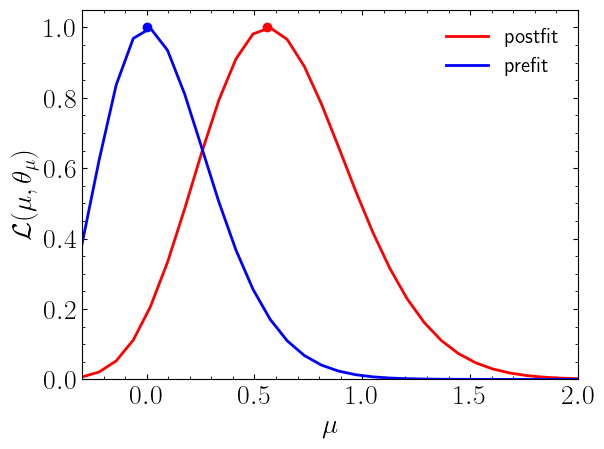

In [11]:
plt.plot(poi, llhd_postfit / max_llhd_postfit, color="r", label="postfit")
plt.scatter(muhat_postfit, 1, color="r")

plt.plot(poi, llhd_prefit / max_llhd_prefit, color="b", label="prefit")
plt.scatter(muhat_prefit, 1, color="b")

plt.legend()

plt.ylabel(r"$\mathcal{L}(\mu,\theta_\mu)$")
plt.xlabel(r"$\mu$")
plt.xlim([-0.3, 2])
plt.ylim([0, 1.05])
plt.show()

### Upper limits and Exclusion level

We can also compute upper limits on $\mu$ and exclusion confidence level, $1-CL_s$, as follows;

In [12]:
print(
    f"Observed upper limit on µ at 95% CL: {corr_background_model.poi_upper_limit():.5f}"
)

expected_pval = corr_background_model.poi_upper_limit(
    expected=spey.ExpectationType.aposteriori, expected_pvalue="1sigma"
)
muUL_apost = expected_pval[1]
print(
    "Expected upper limit on µ with ± 1σ at 95% CL: "
    + ",".join([f"{x:.3f}" for x in expected_pval])
)

Observed upper limit on µ at 95% CL: 1.19567
Expected upper limit on µ with ± 1σ at 95% CL: 0.573,0.766,1.060


In [13]:
print(
    f"Observed upper limit on µ at 68% CL: {corr_background_model.poi_upper_limit(confidence_level=0.68):.5f}"
)

Observed upper limit on µ at 68% CL: 0.75275


Compute it by hand:

In [14]:
poi = np.linspace(0, 1.5, 20)
poiUL = np.array(
    [
        corr_background_model.exclusion_confidence_level(
            poi_test=p, expected=spey.ExpectationType.aposteriori
        )
        for p in poi
    ]
)

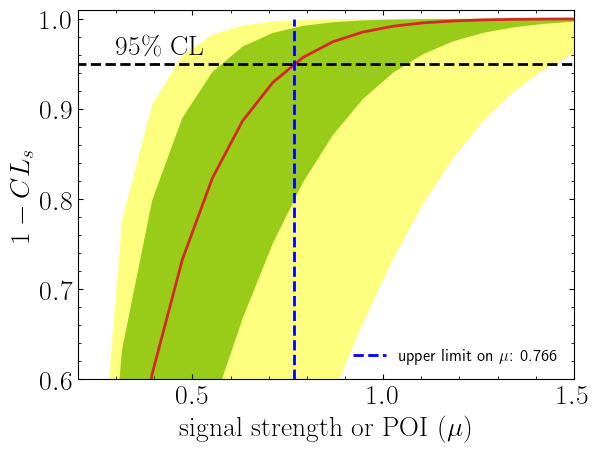

In [15]:
plt.plot(poi, poiUL[:, 2], color="tab:red")
plt.fill_between(poi, poiUL[:, 1], poiUL[:, 3], alpha=0.8, color="green", lw=0)
plt.fill_between(poi, poiUL[:, 0], poiUL[:, 4], alpha=0.5, color="yellow", lw=0)
plt.plot(
    [muUL_apost, muUL_apost],
    [0, 1],
    ls="dashed",
    color="b",
    label=f"upper limit on $\\mu$: {muUL_apost:.3f}",
)
plt.plot([0, 10], [0.95, 0.95], color="k", ls="dashed")
plt.xlabel(r"${\rm signal\ strength\ or\ POI }\ (\mu)$")
plt.ylabel("$1-CL_s$")
plt.xlim([0.2, 1.5])
plt.ylim([0.6, 1.01])
plt.text(0.3, 0.96, r"$95\%\ {\rm CL}$")
plt.legend(fontsize=12)
plt.show()

In [16]:
print(
    f"Observed exclusion confidence level, 1-CLs: {corr_background_model.exclusion_confidence_level()[0]:.5f}"
)

Observed exclusion confidence level, 1-CLs: 0.87378


In [17]:
exp_cls = corr_background_model.exclusion_confidence_level(
    expected=spey.ExpectationType.aposteriori
)
print(
    f"Expected exclusion confidence level, 1-CLs ± 1σ: {exp_cls[2]:.4f} - {exp_cls[2]-exp_cls[3]:.4f} + {exp_cls[1]-exp_cls[2]:.4f}"
)

Expected exclusion confidence level, 1-CLs ± 1σ: 0.9900 - 0.0584 + 0.0089


More details on exclusion limit computation can be found in the dedicated section of the [online documentation](https://speysidehep.github.io/spey/exclusion.html).

### Third Moment Expansion 
Proposed in [Buckley, Citron, Fichet, Kraml, Waltenberger, Wardle; JHEP ‘18](https://arxiv.org/abs/1809.05548)

$$
\mathcal{L}(\mu, \theta) = \prod_{i\in{\rm bins}}{\rm Poiss}(n^i|\mu n_s^i + \bar{n}_b^i + B_i\theta_i + S_i\theta_i^2)
     \cdot \prod_{j\in{\rm nui}}\mathcal{N}(\theta^j|0, \bar{\rho})
$$

* $\bar{n}_b^i$ := the central value of the background
* $B_i$ := the effective sigma of the background uncertainty
* $S_i$ := asymmetry of the background uncertainty

More information can be found in [this link](https://speysidehep.github.io/spey/plugins.html#default-pdf-third-moment-expansion). As before, lets prepare our statistical model:

````{margin}
```{admonition} **Question:** 

***Experimental collaboration provided asymmetric uncertainties but not third moments, can spey compute third moments?***

**Answer:** Yes! one can use [`compute_third_moments`](https://spey.readthedocs.io/en/main/_generated/spey.backends.default_pdf.third_moment.compute_third_moments.html#spey.backends.default_pdf.third_moment.compute_third_moments) function which computes third moments using Bifurcated Gaussian

$$ 
m^{(3)} = \frac{2}{\sigma^+ + \sigma^-} \left[ \sigma^-\int_{-\infty}^0 x^3\mathcal{N}(x|0,\sigma^-)dx + \sigma^+ \int_0^{\infty} x^3\mathcal{N}(x|0,\sigma^+)dx \right]
$$

But this is an assumption, if collaboration provides exact third moments, please always use those. 
```
````

In [18]:
pdf_wrapper = spey.get_backend("default_pdf.third_moment_expansion")
third_mom_expansion_model = pdf_wrapper(
    signal_yields=signal_yields,
    background_yields=background_yields,
    data=observations,
    covariance_matrix=covariance_matrix,
    third_moment=third_moments,
    analysis="cms-sus-20-004-TM",
)
print(third_mom_expansion_model)

StatisticalModel(analysis='cms-sus-20-004-TM', backend=default_pdf.third_moment_expansion, calculators=['toy', 'asymptotic', 'chi_square'])


In [19]:
print(f"Observed upper limit on µ: {third_mom_expansion_model.poi_upper_limit():.5f}")
print(
    f"Expected upper limit on µ: {third_mom_expansion_model.poi_upper_limit(expected=spey.ExpectationType.aposteriori):.5f}"
)
print(
    f"Observed exclusion confidence level, 1-CLs: {third_mom_expansion_model.exclusion_confidence_level()[0]:.5f}"
)

Observed upper limit on µ: 1.17409
Expected upper limit on µ: 0.81665
Observed exclusion confidence level, 1-CLs: 0.88504


### Effective Sigma
Proposed in [Barlow; '04](https://arxiv.org/abs/physics/0406120) to fit Gaussian distribution on a Poisson distribution with asymmetric uncertainties. In the paper it has been referred as Variable Gaussian technique, here we will use a modified version of this approach.

$$
\mathcal{L}(\mu, \theta) = \left[\prod_{i\in{\rm bins}}{\rm Poiss}\left(n^i|\mu n_s^i + n_b^i + \theta^i\sigma_{\rm eff}^i(\theta^i)\right) \right]\cdot\mathcal{N}\left(\theta|0, \rho\right)
$$

where $ \sigma_{\rm eff}^i(\theta^i) = \sqrt{\sigma^+_i\sigma^-_i + (\sigma^+_i - \sigma^-_i)(\theta^i - n_b^i)} $. See [this link](https://speysidehep.github.io/spey/plugins.html#default-pdf-effective-sigma) for the documentation of this likelihood prescription. As previous examples, let us initiate the statistical model once more. We will need to convert above covariance matrix into correlation matrix which can be done with [`covariance_to_correlation`](https://spey.readthedocs.io/en/main/_generated/spey.helper_functions.covariance_to_correlation.html#spey.helper_functions.covariance_to_correlation).

In [20]:
from spey.helper_functions import covariance_to_correlation

In [21]:
pdf_wrapper = spey.get_backend("default_pdf.effective_sigma")
effective_sigma_model = pdf_wrapper(
    signal_yields=signal_yields,
    background_yields=background_yields,
    data=observations,
    correlation_matrix=covariance_to_correlation(covariance_matrix),
    absolute_uncertainty_envelops=[
        (up, dn) for up, dn in zip(upper_unc_envelope, lower_unc_envelope)
    ],
    analysis="cms-sus-20-004-ES",
)
print(effective_sigma_model)

StatisticalModel(analysis='cms-sus-20-004-ES', backend=default_pdf.effective_sigma, calculators=['toy', 'asymptotic', 'chi_square'])


In [22]:
print(f"Observed upper limit on µ: {effective_sigma_model.poi_upper_limit():.5f}")
print(
    f"Expected upper limit on µ: {effective_sigma_model.poi_upper_limit(expected=spey.ExpectationType.aposteriori):.5f}"
)
print(
    f"Observed exclusion confidence level, 1-CLs: {effective_sigma_model.exclusion_confidence_level()[0]:.5f}"
)

Observed upper limit on µ: 0.92033
Expected upper limit on µ: 0.66874
Observed exclusion confidence level, 1-CLs: 0.96993


Lets compare $\chi^2(\mu)$ distribution for all three likelihoods

In [24]:
poi = np.linspace(0, 3, 30)

llhd = [corr_background_model.chi2(p) for p in poi]
llhd_tm = [third_mom_expansion_model.chi2(p) for p in poi]
llhd_es = [effective_sigma_model.chi2(p) for p in poi]

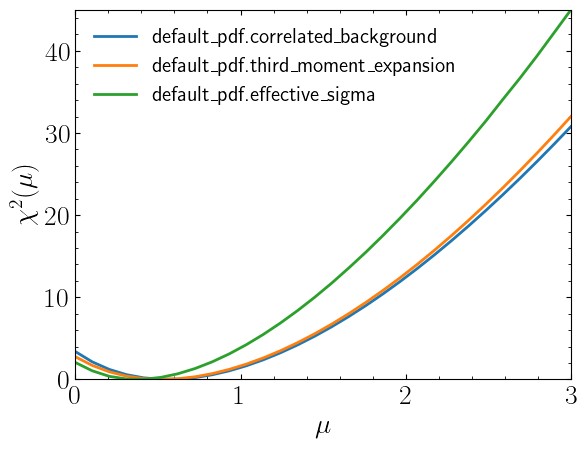

In [25]:
plt.plot(poi, llhd, label=corr_background_model.backend_type)
plt.plot(poi, llhd_tm, label=third_mom_expansion_model.backend_type)
plt.plot(poi, llhd_es, label=effective_sigma_model.backend_type)
plt.legend()
plt.ylabel(r"$\chi^2(\mu)$")
plt.xlabel(r"$\mu$")
plt.xlim([0, 3])
plt.ylim([0, 45])
plt.show()